<a href="https://colab.research.google.com/github/10-ThiagoB82/Projetos-Publico/blob/main/Clusterizacao_Segmentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Segmentação de Clientes

>Utilizando o banco de dados da Olist com K-means para identificar a frequência, recência e receita dos consumidores e agrupa-los em categorias de compras. Assim podemos fazer campanhas de marketing específicas, além de criar programas de recompensas para os clientes que mais consomem.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
df=pd.read_csv('BancoDeDados.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
amostra                 116581 non-null int64
id_cliente              116581 non-null object
id_unico_cliente        116581 non-null object
item_id                 116581 non-null int64
cep_cliente             116581 non-null int64
cidade_cliente          116581 non-null object
estado_cliente          116581 non-null object
id_pedido               116581 non-null object
status_pedido           116581 non-null object
horario_pedido          116581 non-null object
pedido_aprovado         116567 non-null object
pedido_entregador       115368 non-null object
pedido_entregue         114066 non-null object
data_estimada           116581 non-null object
id_vendedor             116581 non-null object
preco                   116581 non-null float64
frete                   116581 non-null float64
pagamento_sequencial    116581 non-null int64
pagamento_tipo          116581 non-null objec

In [ ]:
df.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,...,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


### Análise Exploratória

In [ ]:
def plot_perc(st,dados):
    plt.figure(figsize=(20,8))

    g = sns.countplot(x=st, data=dados, orient='h')
    g.set_title("Distribuição do estado dos clientes", fontsize=20)
    g.set_xlabel("Estado", fontsize=17)
    g.set_ylabel("Contagem", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/1.6,
            height + 200,
            '{:1.2f}%'.format(height/116581*100),
            ha="center", va='bottom',fontsize=12) 
    g.set_ylim(0, max(sizes) * 1.1)

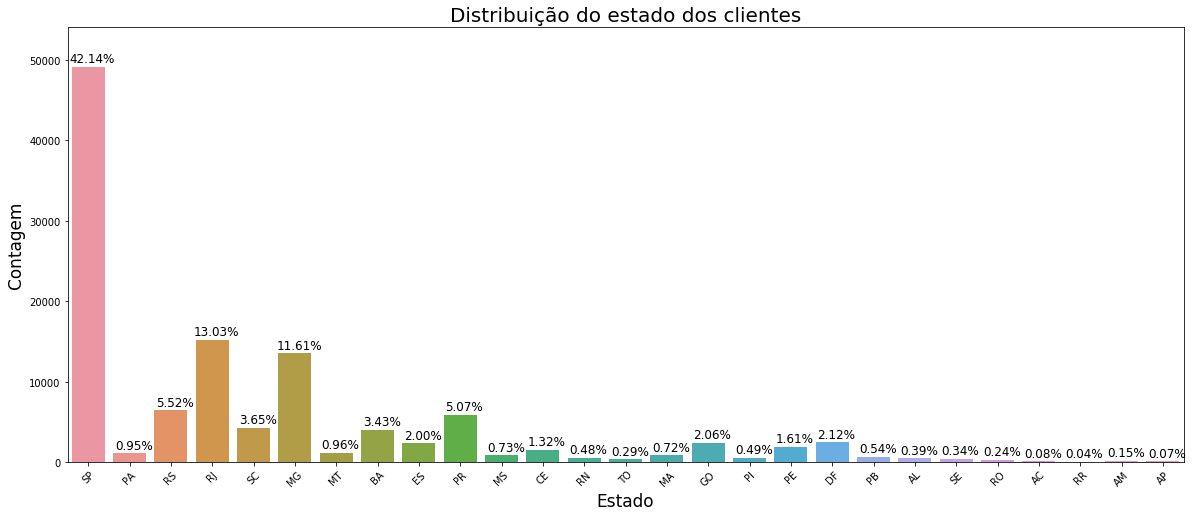

In [ ]:
plot_perc('estado_cliente',df)

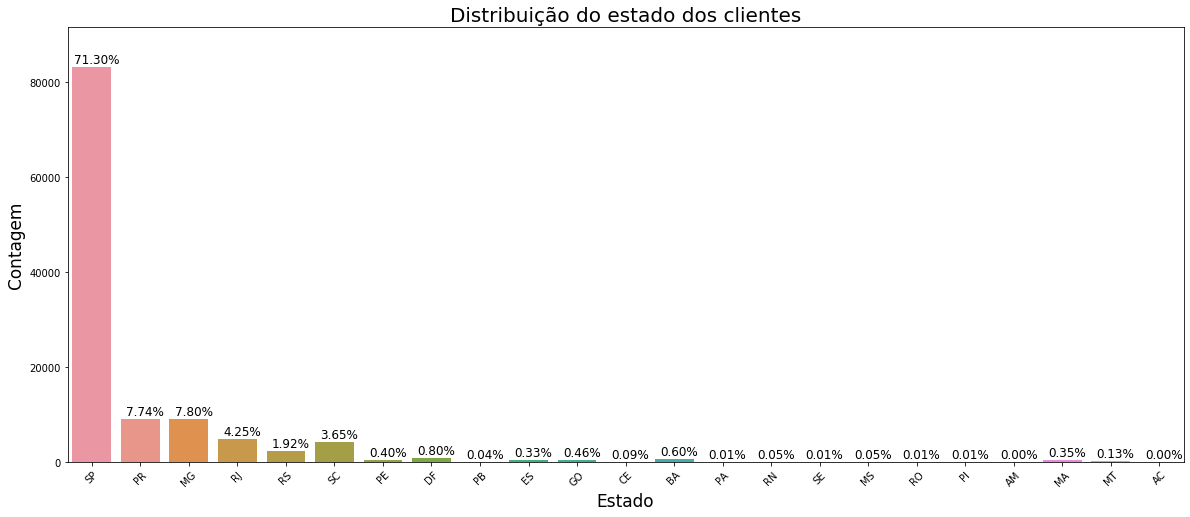

In [ ]:
plot_perc('estado_vendedor',df)

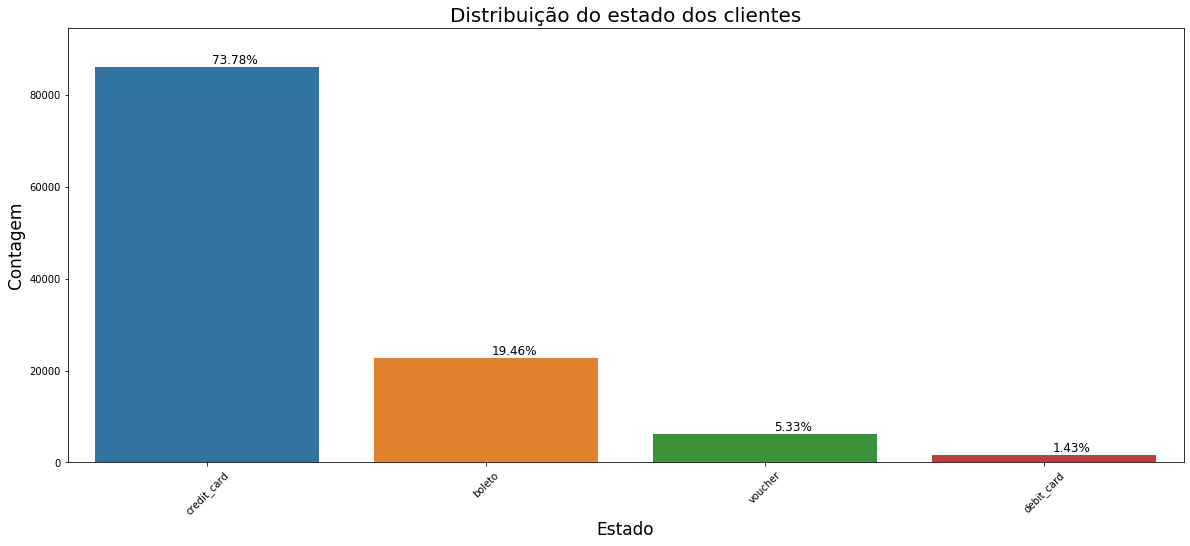

In [ ]:
plot_perc('pagamento_tipo',df)

- Identificamos primeiramente que a maioria dos clientes realiza compras por cartão de crédito, posteriormente por boleto, voucher e cartão de débito. Seria interessante aumentar as promoções para pagamento à vista (para aumento dos pagamentos com boleto ou cartão de débito).
- Também percebe-se que a maioria dos vendedores e compradores estão em SP.

> Agora que temos um banco de dados completo, podemos salva-lo para utilizar posteriormente. Também vou criar um novo banco de dados apenas com as informações que vou precisar para fazer a análise de recẽncia, frequência e receita.

In [ ]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']]

In [ ]:
df_compra = df.groupby('id_unico_cliente').horario_pedido.max().reset_index()
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra']

In [ ]:
df_compra['DataMaxCompra']= pd.to_datetime(df_compra['DataMaxCompra']) 

> Precisamos definir agora as três variáveis que utilizaremos para segmentação: **recência**, **frequência** e **receita**. Em inglês, é chamado de método RFM. Este é um método utilizado para analisar o comportamento do cliente e definir segmentos de mercado. :

> - Recência: quão recentemente um cliente fez uma compra. É um importante preditor, pois um cliente que comprou há pouco tempo tem mais chance de voltar a comprar do que aquele que comprou há muito tempo, além de apresentar uma probabilidade maior de responder a promoções.
- Frequência: com que frequência um cliente faz uma compra.  Se um cliente compra frequentemente, espera-se que ele volte a comprar.
- Receita: quanto dinheiro um cliente gasta em compras. Aqueles clientes que gastaram muito têm mais valor para a organização em comparação com aqueles que gastaram menos

In [ ]:
#seleciona o ponto de observação como a data máxima de compra em nosso df
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days

#junta esse df com o nosso novo chamado df_user
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente','Recencia']], on='id_unico_cliente')

df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211


In [ ]:
# plotando a distribuição da feature continua que acabamos de identificar
#def dist(dados):
#    sns.set(palette='muted', color_codes=True, style='white')
#    fig, ax = plt.subplots(figsize=(12, 6))
#    sns.despine(left=True)
#    sns.distplot(dados, bins=30)
#    plt.show()

In [ ]:
#dist(df_usuario['Recencia'])

In [ ]:
def calcular_wcss(data):
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=data)
        data["clusters"] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

> Agora precisamos usar o Método Cotovelo, a ideia é rodar o KMeans para várias quantidades diferentes de clusters e dizer qual dessas quantidades é o número ótimo de clusters. Usando a "regra do cotovelo", identificamos que a partir de 4 clusters teremos bons resultados. Vou usar 5 apenas para garantir.

> O que geralmente acontece ao aumentar a quantidade de clusters no KMeans é que as diferenças entre clusters se tornam muito pequenas, e as diferenças das observações intra-clusters vão aumentando. Então é preciso achar um equilíbrio em que as observações que formam cada agrupamento sejam o mais homogêneas possível e que os agrupamentos formados sejam o mais diferentes um dos outros.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.cluster import KMeans

df_recencia = df_usuario[['Recencia']]
soma_quadrados = calcular_wcss(df_recencia)

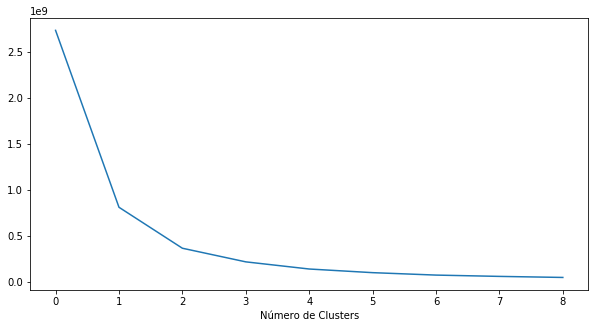

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(soma_quadrados)
plt.xlabel("Número de Clusters")
plt.show()

> Mas como podemos identificar se o melhor número de clusters é 3, 4 ou 5? Existe uma solução matemática! Primeiramente, definimos uma reta ligando o primeiro ponto (cluster 1) ao último ponto (cluster 9). Então, calculamos a distância de cada ponto até a reta usando a seguinte equação:

![](https://miro.medium.com/max/2775/1*9J7Wnh5L0eIcHXBeWlzvNA.png)

> Neste caso, P0 é o ponto do cluster 1 e P1 o ponto do cluster 9. O par (x,y) representa as coordenadas de qualquer ponto que a gente queira calcular a distância. Calculando todas as distância, conseguimos determinar o ponto ideal!

In [ ]:
import math
def numero_otimo_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distancias = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerador = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancias.append(numerador/denominador)
    
    return distancias.index(max(distancias)) + 2

In [ ]:
# calculando a soma dos quadrados para as quantidade de clusters
soma_quadrados = calcular_wcss(df_recencia)

# calculando a quantidade ótima de clusters
n = numero_otimo_clusters(soma_quadrados)

> E agora o número ideal de clusters!

In [ ]:
n

4

In [ ]:
# rodando o kmeans para nossa quantidade ótima de clusters
kmeans = KMeans(n_clusters=4)
df_usuario['RecenciaCluster'] = kmeans.fit_predict(df_recencia)

In [ ]:
#função para ordenar o número de clusters 
def ordenar_cluster(cluster_nome, target_nome,df,ascending):
    novo_nome = 'novo' + cluster_nome
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                     ascending=ascending).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns={"index":cluster_nome})
    return df_final

df_usuario = ordenar_cluster('RecenciaCluster', 'Recencia',df_usuario,False)

In [ ]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,20524.0,489.787907,59.600038,405.0,443.0,481.0,532.0,728.0
1,30757.0,319.404298,43.691600,254.0,281.0,313.0,356.0,404.0
2,33712.0,187.293338,35.169771,127.0,158.0,187.0,218.0,253.0
3,31588.0,66.405850,35.800016,0.0,33.0,67.0,99.0,126.0


In [ ]:
# cria um df com a quantidade de ordens para cada cliente
df_frequencia = df.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente','Frequencia']

# adiciona esses dados em nosso df principal
df_usuario = pd.merge(df_usuario, df_frequencia, on='id_unico_cliente')

In [ ]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1


In [ ]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_frequencia = df_usuario[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)

In [ ]:
# ordena os clusters de frequência
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0
2,731.0,21.489740,6.588977,14.0,15.0,21.0,24.0,38.0
3,9205.0,5.644432,2.138491,4.0,4.0,5.0,6.0,13.0


In [ ]:
#calcula a receita para cada cliente
df_receita = df.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()

#junta com o df principal
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')

In [ ]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_pagamento = df_usuario[['pagamento_valor']]
kmeans = KMeans(n_clusters=4)
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)

In [ ]:
#ordena os clusters
df_usuario.groupby('ReceitaCluster')['pagamento_valor'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114763.0,258.095126,364.892800,9.59,69.90,132.57,269.10,2950.16
1,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
2,1619.0,5650.053385,2881.999747,2951.83,3557.12,4491.44,6914.63,16313.60
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


In [ ]:
df_final = df_usuario.drop(['id_cliente','horario_pedido','item_id','preco'],axis=1)
df_final.head()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,pagamento_valor,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0


In [ ]:
#renomeando as colunas
df_final.columns = ['Id_unico_cliente', 'Recencia', 'RecenciaCluster', 'Frequencia', 'FrequenciaCluster', 'Receita', 'ReceitaCluster']

In [ ]:
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,0,148.33,0


In [ ]:
df_final = ordenar_cluster('FrequenciaCluster', 'ReceitaCluster',df_final,False)

> Calcularemos a pontuação geral do cliente baseado nesses clusters e também definimos 4 opções: inativo, business, master e premium. 

In [ ]:
df_final['Pontuacao'] = df_usuario['RecenciaCluster'] + df_usuario['FrequenciaCluster'] + df_usuario['ReceitaCluster']
df_final.groupby('Pontuacao')['Recencia','Frequencia','Receita'].mean()
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,Receita,ReceitaCluster,FrequenciaCluster,Pontuacao
0,861eff4711a542e4b93843c6dd7febb0,474,0,1,146.87,0,2,0
1,3c799d181c34d51f6d44bbbc563024db,483,0,1,140.61,0,2,0
2,567ab47ca4deb92d46dbf54dce07d0a7,528,0,1,142.05,0,2,0
3,f40ab89b622248b7ca125af4b486b887,474,0,1,155.70,0,2,0
4,749943913a9851a39c9baf51877fbab6,533,0,1,148.33,0,2,0


In [ ]:
df_final['Segmento'] = 'Inativo'

In [ ]:
df_final.loc[df_final['Pontuacao']>=3,'Segmento'] = 'Business' 
df_final.loc[df_final['Pontuacao']>=6,'Segmento'] = 'Master' 
df_final.loc[df_final['Pontuacao']>=8,'Segmento'] = 'Premium' 

In [ ]:
df_final.to_csv('RFM.csv')

In [ ]:
def plot_segmento(x,y,data):
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, axs = plt.subplots(1, 1, figsize=(7, 5))
    sns.despine(left=True)
    sns.scatterplot(x=x, y=y, hue='Segmento', data=data, size='Segmento', sizes=(50,150), size_order=['Premium','Master','Business','Inativo'])
    axs.set_title('Segmento de Cliente')
    plt.show()

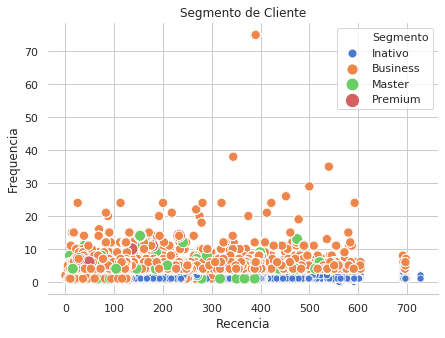

In [ ]:
plot_segmento('Recencia','Frequencia',df_final)

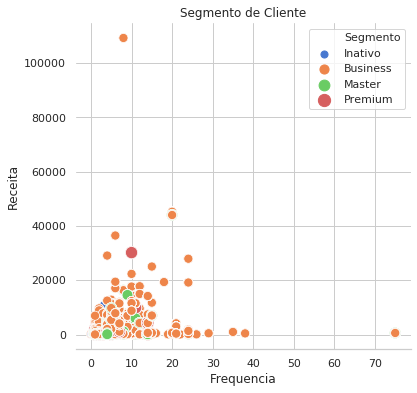

In [ ]:
plot_segmento('Frequencia','Receita',df_final)

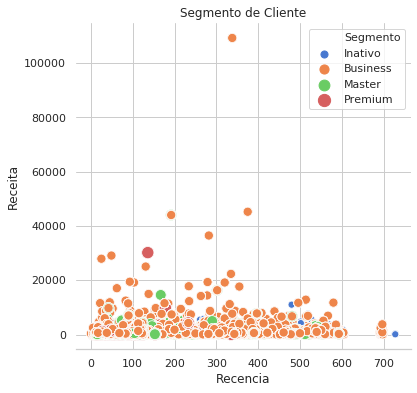

In [ ]:
plot_segmento('Recencia','Receita',df_final)

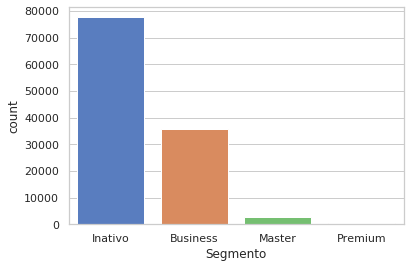

In [ ]:
sns.countplot(df_final['Segmento'])

>Modelamos com um dos métodos mais utilizados de cliusterização, o K-means, e também como podemos determinar matematicamente o melhor número de clientes. Por fim, conseguimos dividir os clientes com base em seu comportamento. Podemos também criar outros tipos de segmentação com base nas campanhas de marketing que queremos explorar. É importante ressaltar que esse é apenas um dos vários métodos de clusterização e que existem outros tipos de algoritmos e de separações que podemos fazer. Neste caso, fizemos uma clusterização com base na pontuação, ou seja, clientes que compram muito, mas com pouca frequência podem acabar tendo uma pontuação semelhante aos que gastam menos, mas com mais frequência. Para fazer uma análise mais completa, poderíamos criar uma tabela inteira se nos basearmos em uma pontuação de 1 a 5 como o exemplo abaixo:

| **Segmentos**        | **Descrição**                                                      | **Recência** | **Frequência** | **Receita** |
|----------------------|--------------------------------------------------------------------|--------------|----------------|-------------|
| Campeões             | Compraram recentemente, compram com frequência e gastam muito      | 4-5          | 4-5            | 4-5         |
| Clientes fiéis       | Gastam muito e respondem a promoções                               | 2-5          | 3-5            | 3-5         |
| Potencialmente fiéis | Compraram recentemente, mais de uma vez e gastaram uma boa quantia | 3-5          | 1-3            | 1-3         |
| Novos clientes       | Compraram recentemente, mas não compram com frequência             | 4-5          | <=1            | <=1         |
| Promissores          | Compraram recentemente, mas não gastaram muito                     | 3-4          | <=1            | <=1         |
| Precisam de atenção  | Recência, frequência e valor monetário acima da média              | 2-3          | 2-3            | 2-3         |
| Quase em risco       | Recência, frequência e valor monetário abaixo da média             | 2-3          | <=2            | <=2         |
| De risco             | Gastaram muito, compraram muitas vezes, mas há muito tempo         | <=2          | 2-5            | 2-5         |
| Não pode perdê-los   | Compraram muito e com frequência, mas há muito tempo               | <=1          | 4-5            | 4-5         |
| Hibernando           | Compraram pouco, com baixa frequência e há muito tempo             | 1-2          | 1-2            | 1-2         |
| Perdidos             | Recência, frequência e valores monetários baixos                   | <=2          | <=2            | <=2         |

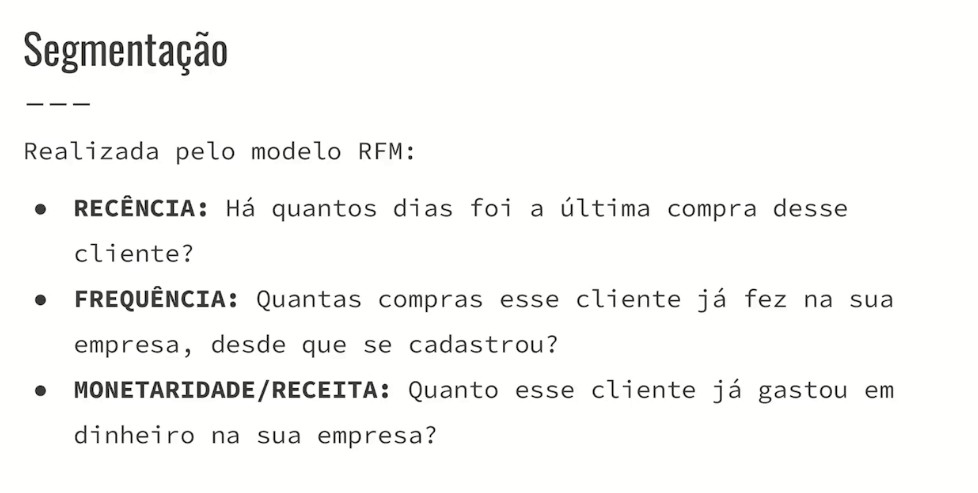

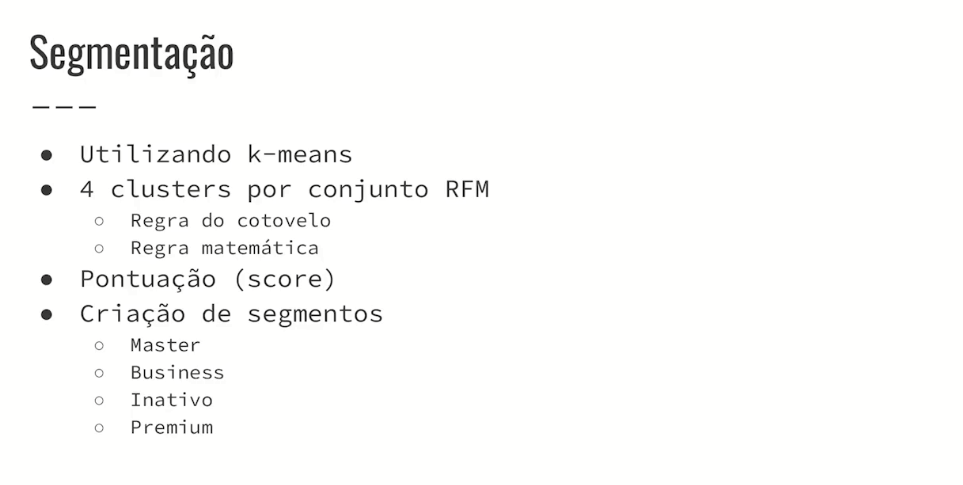

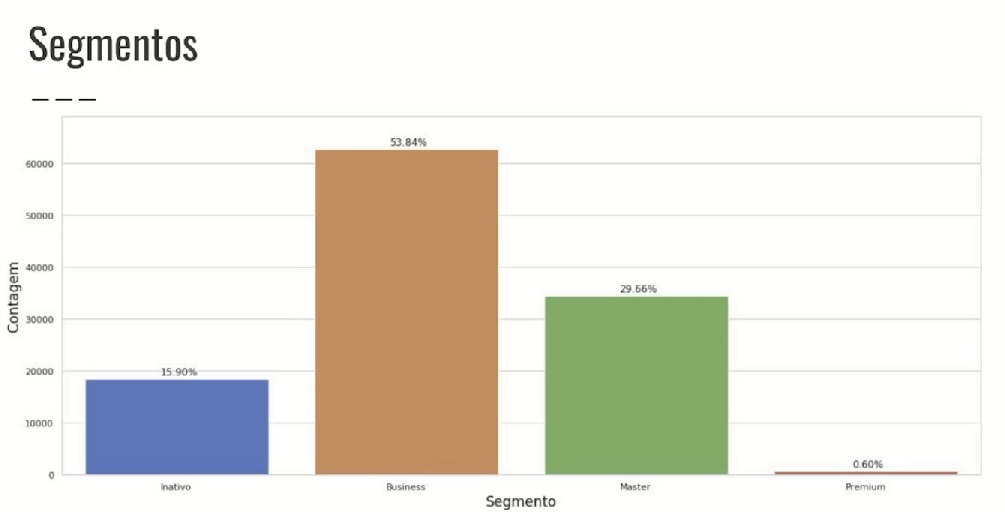

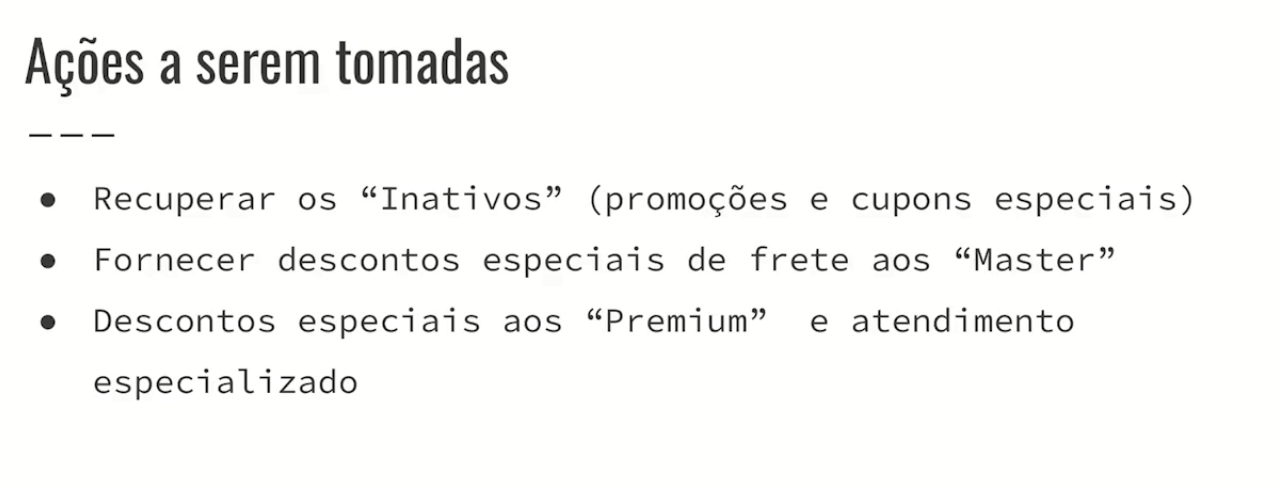

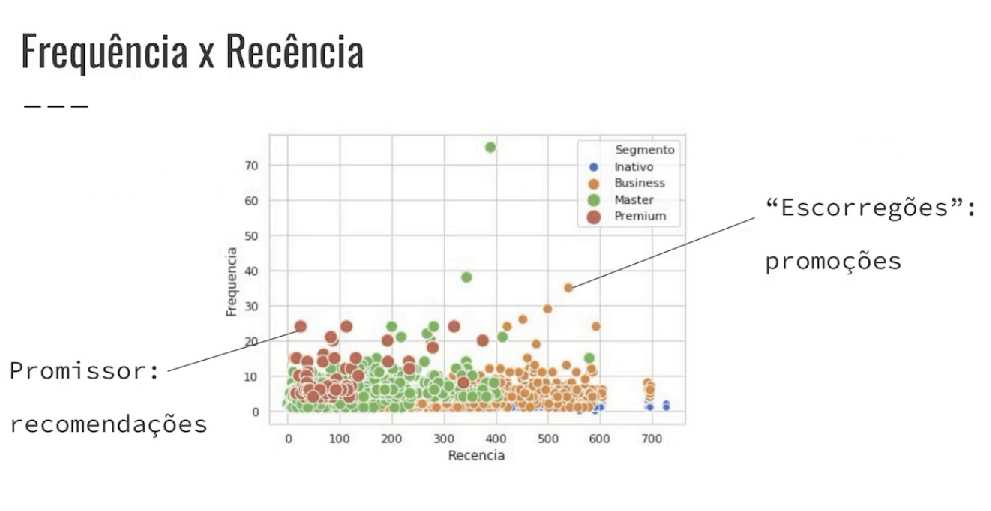

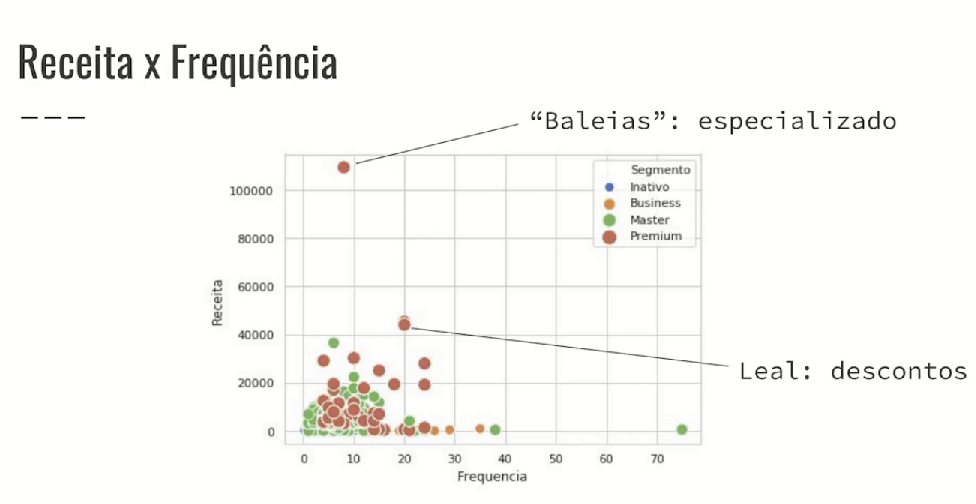

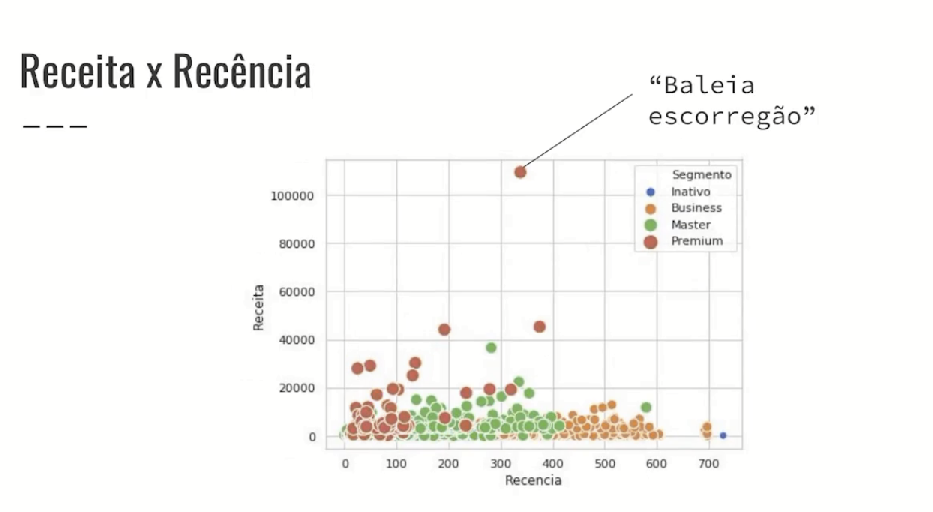